In [181]:
# Import standard libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats 
import cdt
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

# 1.  Load data sets 

In [182]:
#load experimental data 
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
#load non experimental data (cps)
cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls2.dta")
cps3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls3.dta")
#load non experimental data (psid)
psid1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")
psid2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls2.dta")
psid3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls3.dta")
cps1['treat'] == 1

nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
#Combine treatment and control
nswre74 = pd.concat([nswre74_control,nswre74_treated])

In [53]:
# Clean up data 
#Convert to numberic 
for i in nsw.columns:
  pd.to_numeric(nsw[i])

# Take natural log of outcome 
nsw['re78'].replace(to_replace = 0, value = 1 , inplace=True)
nsw['re78']  = np.log(nsw['re78'])

# Take natural log of wages 1975 
nsw['re75'].replace(to_replace = 0, value = 1 , inplace=True)
nsw['re75']  = np.log(nsw['re75'])

# round
nsw['re78'] = round(nsw['re78'],2)
nsw['re75'] = round(nsw['re75'],2)

nswre74['idx'] = range(1, len(nswre74) + 1)

# Exploratory Analysis

In [185]:
# Helper functions for plotting

def quick_plot_2(dataset,variable,variable2,variable3):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==1)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==1) & (nsw[variable3]==0)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==0)])
  return 

def quick_mean_sd(dataset):
  nsw_teatment_subsample = dataset[dataset['treat']==1]
  nsw_control_subsample = dataset[dataset['treat']==0]
  treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
  control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T
  treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)
  superlables = {'treated':['mean','sd'],'control':['mean','sd']}
  treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
  return print(treat_control_comparison)
  
def quick_plot(dataset,var1,var2):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==1],color = 'firebrick',label= str(var2)+'_1')
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==0],color = 'forestgreen',label= str(var2)+'_0')
  plt.legend(fontsize=15)
  return 


<p> Descriptive statistics for datasets </p>

In [186]:
#Further sumbsample
nsw_degree = nsw[nsw['nodegree']==1]
nsw_nodegree = nsw[nsw['nodegree']==0]

# has degree subsample
nsw_teatment_degree_subsample = nsw_degree[nsw_degree['treat']==1]
nsw_control_degree_subsample = nsw_degree[nsw_degree['treat']==0]

# no degree subsample
nsw_teatment_nodegree_subsample = nsw_nodegree[nsw_nodegree['treat']==1]
nsw_control_nodegree_subsample = nsw_nodegree[nsw_nodegree['treat']==0]

# degree mean sd
nsw_teatment_degree_subsample = nsw_teatment_degree_subsample.describe().loc[['mean','std']].T
nsw_control_degree_subsample = nsw_control_degree_subsample.describe().loc[['mean','std']].T
# no degree mean sd
nsw_teatment_nodegree_subsample = nsw_control_nodegree_subsample.describe().loc[['mean','std']].T
nsw_control_nodegree_subsample = nsw_control_nodegree_subsample.describe().loc[['mean','std']].T

# tabulate 
treat_control_degree_comparison = pd.concat([nsw_teatment_degree_subsample, nsw_control_degree_subsample], axis=1)
treat_control_no_degree_comparison = pd.concat([nsw_teatment_nodegree_subsample, nsw_control_nodegree_subsample], axis=1)

superlables = {'treated degree':['mean','sd'],'control degree':['mean','sd']}
superlables2 = {'treated no degree':['mean','sd'],'control no degree':['mean','sd']}

treat_control_degree_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
treat_control_no_degree_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables2).melt())

# comabine all tables
four_groups = pd.concat([treat_control_degree_comparison, treat_control_no_degree_comparison], axis=1)

four_groups

variable  treated degree              control degree               \
value               mean           sd           mean           sd   
treat           1.000000     0.000000       0.000000     0.000000   
age            24.276498     6.892498      23.982659     6.802364   
education       9.640553     1.496853       9.705202     1.370423   
black           0.811060     0.392366       0.806358     0.395724   
hispanic        0.110599     0.314360       0.124277     0.330376   
married         0.170507     0.376947       0.153179     0.360682   
nodegree        1.000000     0.000000       1.000000     0.000000   
re75         2984.182617  4897.564453    2727.997559  4801.812988   
re78         5607.335938  6594.434570    4900.867188  5608.822754   

variable  treated no degree              control no degree               
value                  mean           sd              mean           sd  
treat              0.000000     0.000000          0.000000     0.000000  
age               26.481013     5.126254         26.481013     5.126254  
education         12.303797     0.606681         12.303797     0.606681  
black              0.772152     0.422124          0.772152     0.422124  
hispanic           0.063291     0.245042          0.063291     0.245042  
married            0.177215     0.384291          0.177215     0.384291  
nodegree           0.000000     0.000000          0.000000     0.000000  
re75            4334.848145  6553.137695       4334.848145  6553.137695  
re78            5918.607422  6142.960938       5918.607422  6142.960938

<p> Taking logs of wage reveals that the distribution is bimodal </p>
<p> There are a group of low wage earners (o mode) and higher wave earns (c8 mode) </p>
<p> Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

### Outlier detection

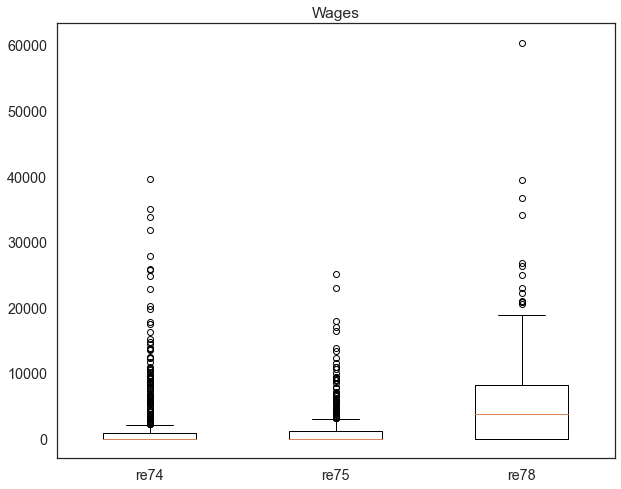

In [188]:
plt.boxplot([nswre74['re74'],nswre74['re75'],nswre74['re78']], widths=0.5)
plt.xticks([1,2,3],['re74', 're75','re78'])
plt.title('Wages')
plt.show()

Text(0.5, 1.0, 'age and education')

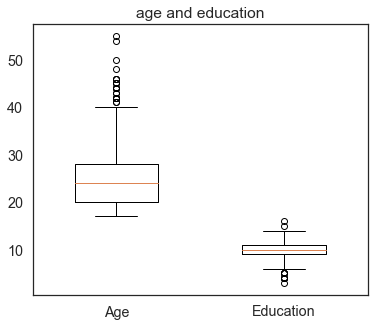

In [189]:
fig = plt.figure(figsize=(6,5))
plt.boxplot([nswre74['age'],nswre74['education']], widths=0.5)
plt.xticks([1,2,],['Age', 'Education'])
plt.title('age and education')

### Plot histograms comparing outcome from those with and without degrees

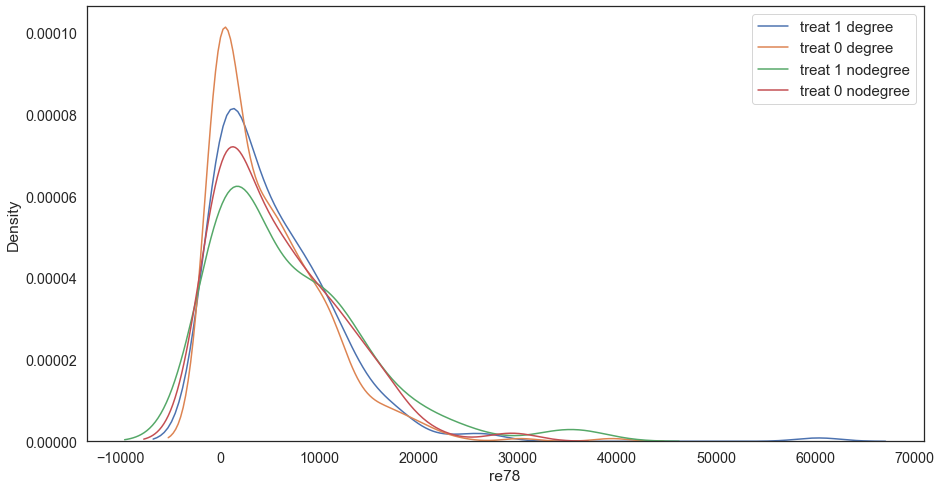

In [190]:
plt.figure(figsize=(15,8))
# Density plots for treatment and control
sns.kdeplot(data=nsw['re78'][(nsw['treat']==1) & (nsw['nodegree']==1)],label="treat 1 degree")
sns.kdeplot(data=nsw['re78'][(nsw['treat']==0) & (nsw['nodegree']==1)],label="treat 0 degree")
sns.kdeplot(data=nsw['re78'][(nsw['treat']==1) & (nsw['nodegree']==0)],label="treat 1 nodegree")
sns.kdeplot(data=nsw['re78'][(nsw['treat']==0) & (nsw['nodegree']==0)],label="treat 0 nodegree")
plt.legend(fontsize=15)

# Lalonde Observational study data

In [191]:
# (Dehejia-Wahba) subsetted sample of NSW dataset to include 1974 earnings 
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
#Combine treatment and control
nswre74 = pd.concat([nswre74_control,nswre74_treated])
nswre74['idx'] = range(1, len(nswre74) + 1)
#load non experimental data sets (psid and cps1)
# cps data
cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls2.dta")
cps3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls3.dta")

cps1.drop('data_id', axis=1, inplace=True)
cps2.drop('data_id', axis=1, inplace=True)
cps3.drop('data_id', axis=1, inplace=True)

cps1['idx'] = range(1, len(cps1) + 1)
cps2['idx'] = range(1, len(cps2) + 1)
cps3['idx'] = range(1, len(cps3) + 1)

psid1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")


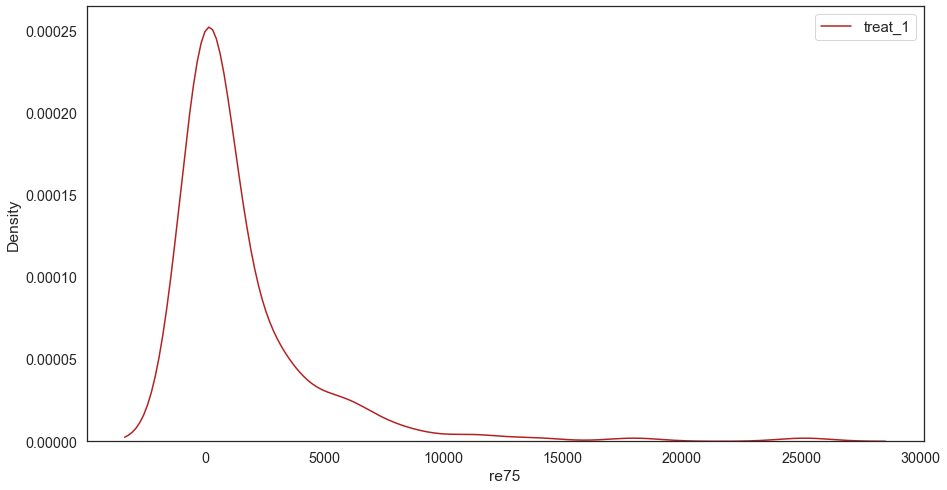

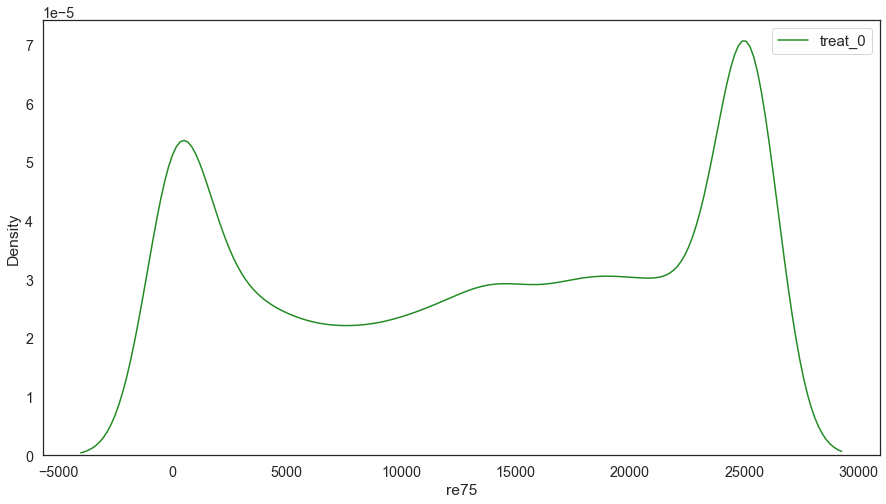

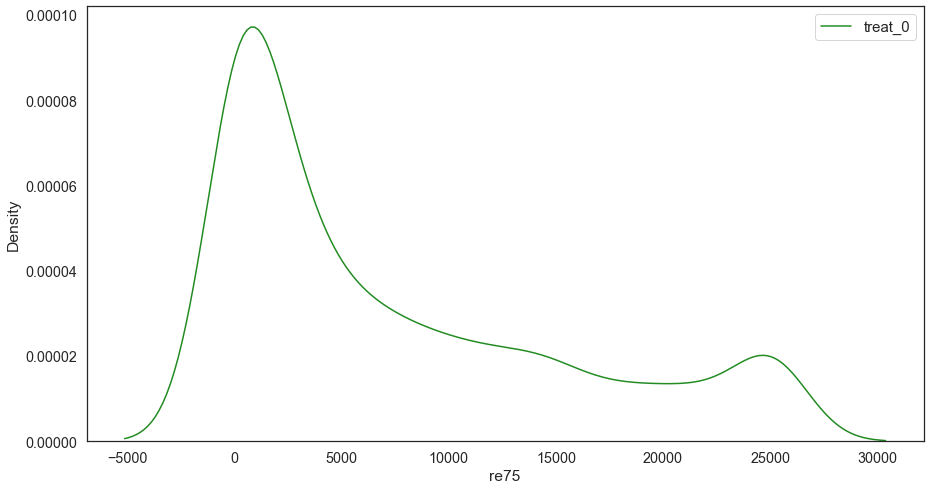

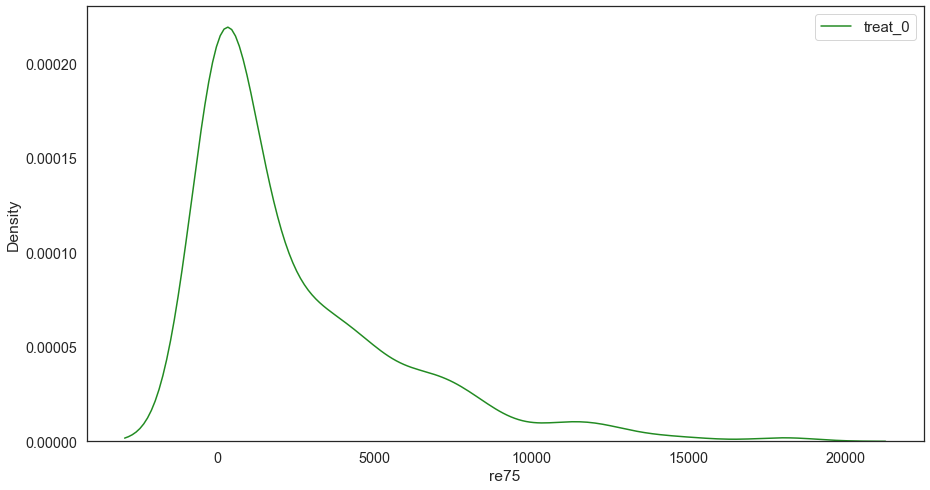

In [192]:
quick_plot(nswre74_treated,"re75",'treat')
quick_plot(cps1,"re75",'treat')
quick_plot(cps2,"re75",'treat')
quick_plot(cps3,"re75",'treat')

## Tabular statistics 

In [175]:
# Comparison groups 

cps1['index'] = range(1, len(cps1) + 1)
cps1_no_observations = sum(cps1['index'].value_counts())


# Current population Survey-social security
cps1['re74']
cps1['re75']
cps1['re78']

# Tabulate Mean and standard deviation of earnings for 1974 - 1975

mean_sd_earnings_74 = cps1['re74'].describe().loc[['mean','std']].T
mean_sd_earnings_75 = cps1['re75'].describe().loc[['mean','std']].T
mean_sd_earnings_78 = cps1['re78'].describe().loc[['mean','std']].T

cps1_earings_mean_sd= pd.concat([mean_sd_earnings_74,mean_sd_earnings_75,mean_sd_earnings_78],axis=1)
cps1_earings_mean_sd = cps1_earings_mean_sd.T

print(cps1_earings_mean_sd)

              mean          std
re74  14016.423828  9569.904297
re75  13650.932617  9270.392578
re78  14847.295898  9647.392578


## Create composite data sets
<p> Create different composite datasets for matching with the treatement group</p>

In [193]:
# Compose dataset of treated units from trial with units from cps1
nsw1_cps1_composite = pd.concat([nswre74_treated,cps1],axis=0)
nsw1_cps1_composite.drop('idx', axis=1, inplace=True)
nsw1_cps1_composite['idx'] = range(1, len(nsw1_cps1_composite) + 1)

# Compose dataset of treated units from trial with units from cps2
nswre74_cps2_composite = pd.concat([nswre74_treated,cps2],axis=0)
nswre74_cps2_composite.drop('idx', axis=1, inplace=True)
nswre74_cps2_composite['idx'] = range(1, len(nswre74_cps2_composite) + 1)

# Compose dataset of treated units from trial with units from cps3
nswre74_cps3_composite = pd.concat([nswre74_treated,cps3],axis=0)
nswre74_cps3_composite.drop('idx', axis=1, inplace=True)
nswre74_cps3_composite['idx'] = range(1, len(nswre74_cps3_composite) + 1)

In [62]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

# PS estimating and Matching methods

In [292]:
# reload datasets for estimation and matching 
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
nswre74_treated.drop('treat', axis=1, inplace=True)

cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")

cps1.drop('data_id', axis=1, inplace=True)
cps1.drop('treat', axis=1, inplace=True)

### Matching 1 - Artifical Neural networks 

#### define ANN class 

In [293]:
class twoLayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [294]:
# Data preprocessing for ANN 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Rescale continous variables for CPS data set 
cps1[['age','education','re74','re75','re78']] = sc.fit_transform(cps1[['age','education','re74','re75','re78']])
# Rescale continous variables for NSW data set 
nswre74_treated[['age','education','re74','re75','re78']] = sc.fit_transform(nswre74_treated[['age','education','re74','re75','re78']])
# Convert features into tensors for ANN 
# CPS dataset 
features_df_cps = cps1
features_array_cps = np.array(features_df_cps)
FEATURES_cps = torch.tensor(features_array_cps)
#NSW dataset 
features_df_nsw = nswre74_treated
features_array_nsw = np.array(features_df_nsw)
FEATURES_nsw = torch.tensor(features_array_nsw)
FEATURES_nsw = FEATURES_nsw.float()


In [295]:
# Neural netowrk hyper paramaters 
NUM_FEATURES = FEATURES_cps.shape[1]
NUM_HIDDEN_1 = 500
NUM_HIDDEN_2 = 250
NUM_HIDDEN_3 = 50
NUM_HIDDEN_4 = 25 
NUM_HIDDEN_5 = 12            
NUM_CLASSES = 1
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.0001

In [296]:
# Load saved model
model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
model.load_state_dict(torch.load('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/k_cross_ANN.pt'))

<All keys matched successfully>

In [396]:
# Predict propensity scores for CPS and NSW data 
with torch.no_grad():
    model.eval()
    prediction_cps = model(FEATURES_cps)
    prediction_nsw = model(FEATURES_nsw)

prediction_cps = pd.DataFrame(prediction_cps.float().numpy())
prediction_nsw = pd.DataFrame(prediction_nsw.float().numpy())    

In [520]:
# Append predicted PS to dataframes
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx') 
cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps1.drop('data_id', axis=1, inplace=True)

nsw_with_ps = pd.concat([nswre74_treated,prediction_nsw],axis=1)
cps_with_ps = pd.concat([cps1,prediction_cps],axis=1)

nsw_with_ps.rename(columns = {0:'propensity_score'}, inplace = True)
cps_with_ps.rename(columns = {0:'propensity_score'}, inplace = True)
# Calculate the logit of the propensity score
nsw_with_ps['propensity_logit'] = np.log(nsw_with_ps['propensity_score'] / (1-nsw_with_ps['propensity_score']))
cps_with_ps['propensity_logit'] = np.log(cps_with_ps['propensity_score'] / (1-cps_with_ps['propensity_score']))

# Combine two dataframes 
nsw_cps_with_ps  = pd.concat([nsw_with_ps,cps_with_ps],axis=0,ignore_index = True)
#nsw_cps_with_ps['id'] = range(1, len(nsw_cps_with_ps) + 1)

In [618]:
# Remove observations which lie outside min and max estimated propesnity scores 
#max = nsw_cps_with_ps[nsw_cps_with_ps['treat']==1]['propensity_score'].max()
#min = nsw_cps_with_ps[nsw_cps_with_ps['treat']==1]['propensity_score'].min()
#nsw_cps_with_ps = nsw_cps_with_ps.drop(nsw_cps_with_ps[(nsw_cps_with_ps['propensity_score'] > max) | (nsw_cps_with_ps['propensity_score'] < min)].index)
#nsw_cps_with_ps

(0.0, 0.1)

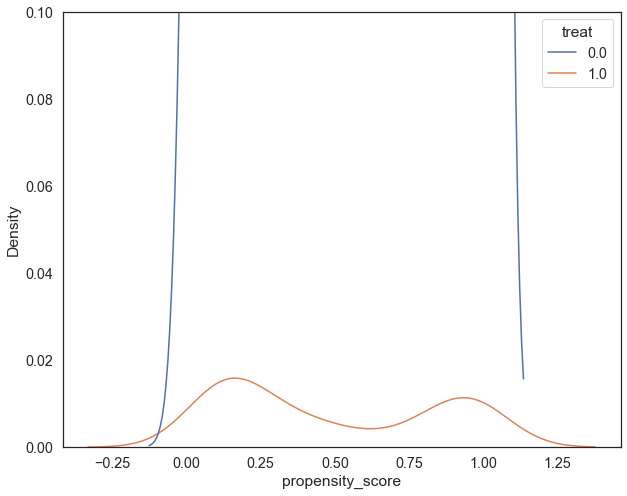

In [619]:
# Check overlap beteen groups
sns.kdeplot(data=nsw_cps_with_ps,x= 'propensity_score', hue= 'treat') 
plt.ylim(0,0.1)

### nearest-neighbour matching

In [660]:
from sklearn.neighbors import NearestNeighbors

caliper = np.std(nsw_cps_with_ps.propensity_score) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 5
# knn setup 
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)
ps = nsw_cps_with_ps[['propensity_score']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0788


NearestNeighbors(radius=0.07882174849510193)

In [661]:
#Matching loop

# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control
distances, neighbor_indexes = knn.kneighbors(ps)
matched_control = []  # keep track of the matched observations in control
neighbours = {} # store ID of matched neighbours to each control 
for current_index, row in nsw_cps_with_ps.iterrows():  # iterate over the dataframe
    if row.treat == 0:  # the current row is in the control group
        nsw_cps_with_ps.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (nsw_cps_with_ps.loc[idx].treat == 0):
                #print(f'treatd id : {current_index} | 'f' matched neighbours : {neighbor_indexes[current_index]} ')
                if idx not in matched_control:  # this control has not been matched yet
                    nsw_cps_with_ps.loc[current_index,'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    neighbours[current_index] = neighbor_indexes[current_index]
                    break

In [662]:
print('total observations in treatment:', len(nsw_cps_with_ps[nsw_cps_with_ps.treat==1]))
print('total matched observations in control:', len(neighbours))

total observations in treatment: 185
total matched observations in control: 184


In [663]:
# Create control group for unit's in matched keys
matched_controls = []
for idx in neighbours.values():  # iterate over the dataframe
    for i in idx:
        matched_controls.append(nsw_cps_with_ps.iloc[i])

matched_controls = pd.DataFrame(matched_controls)
(matched_controls.treat == 0).sum(axis=0) # count number of matched control units 
matched_controls = matched_controls[matched_controls['treat']==0]
matched_controls.drop('matched',axis=1, inplace=True)
len(matched_controls)

712

In [747]:
# generate dataframe with treated and matchd control units 
matched_df = pd.concat([nsw_with_ps,matched_controls])
len(matched_df)
#dataframe before matching for comparison 
before_matched_df = pd.concat([nswre74_treated,cps1])
matched_df = pd.concat([nsw_with_ps,matched_controls],ignore_index=True)
matched_df

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.046000,0.196479,-1.408446
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,0.000000,3595.894000,0.110948,-2.081095
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,0.000000,24909.450000,0.999728,8.207772
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,0.000000,7506.146000,0.108633,-2.104777
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,0.000000,289.789900,0.130304,-1.898275
...,...,...,...,...,...,...,...,...,...,...,...,...
892,0.0,55.0,12.0,0.0,0.0,1.0,0.0,21297.230469,17299.890625,20673.390625,0.943314,2.811866
893,0.0,55.0,17.0,0.0,0.0,0.0,0.0,25862.320312,25243.550781,25564.669922,0.993516,5.031871
894,0.0,55.0,17.0,0.0,0.0,0.0,0.0,25862.320312,25243.550781,25564.669922,0.993516,5.031871
895,0.0,20.0,12.0,0.0,0.0,0.0,0.0,14706.259766,15224.900391,23911.089844,0.993524,5.033222


<p> test distributions</p>

<p> plot distribtions of key variables pre and post matching </p>

(-10000.0, 45000.0)

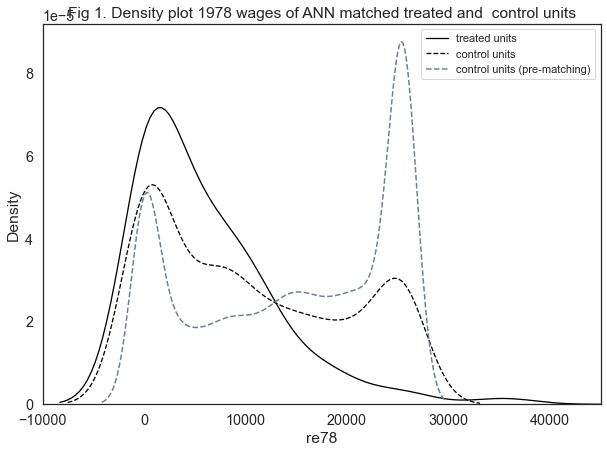

In [745]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['re78'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['re78'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
plt.title('Fig 1. Density plot 1978 wages of ANN matched treated and  control units')
# Density plots pre-matching
sns.kdeplot(before_matched_df['re78'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.legend(fontsize=11,loc = 1)
plt.xlim([-10000, 45000])



(2.0, 21.0)

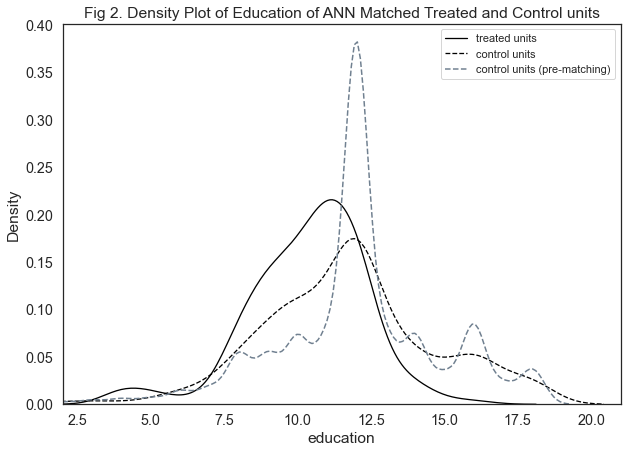

In [753]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['education'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['education'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
sns.kdeplot(before_matched_df['education'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')
plt.title('Fig 2. Density Plot of Education of ANN Matched Treated and Control units')
plt.legend(fontsize=11,loc = 1)
plt.xlim([2, 21])

### Matching 2 - logistic regression